# Load libraries

In [1]:
import os
import sys
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

from functools import partial
import concurrent.futures

sys.path.append('..')
from utils_camels_spat import validate_basin_data, plot_missing_data_heatmap

Matplotlib created a temporary cache directory at /tmp/matplotlib-0b8_mo47 because the default path (/staff/ame805/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


# Constants

In [2]:
dataset = ('CAMELS_spat_NH', 'camels_spat')
countries = ["USA"]
# countries = ["CAN"]

# 'countries' to string and lowercase
countries_str = '-'.join(countries).lower()

NUM_BASINS = 2000
StartDate = "1975-10-01"
EndDate = "2019-09-30"
# StartDate = "1980-10-01"
# EndDate = "2008-09-30"

MULTIPROCESSING = 1

# Functions

In [3]:
# Load 531 basins as reference from 531_basin_file.txt (list of basins IDs)
lines = []
# Open the file in read mode
with open("531_basin_file.txt", 'r') as file:
    # Read each line and append it to the list
    for line in file:
        lines.append(line.strip())  # Remove any leading/trailing whitespace

# Print the lines to verify
basin531_ref = set(lines)

# Run

In [4]:
# Initialize lists to store basin information
selected_basins = []
df_basins_missing = pd.DataFrame()
counter = 0
counter_not_in_ref = 0
not_to_stop = True
for country in countries:
    data_dir = f"../../../../../gladwell/hydrology/SUMMA/summa-ml-models/{dataset[0]}/CAMELS_spat_{country}"
    basins = sorted(os.listdir(data_dir))
    
    if MULTIPROCESSING:
        with concurrent.futures.ProcessPoolExecutor() as executor:
            # Define a partial function to pass the data_dir
            process_basin_partial = partial(validate_basin_data, data_dir=data_dir, start_date=StartDate, end_date=EndDate)
            
            # Process each basin concurrently
            results = [executor.submit(process_basin_partial, basin) for basin in basins]
            
            # Wait for all results to be available
            for result in concurrent.futures.as_completed(results):
                
                basin, basin_ok, date_presence = result.result()
                
                # Append date_presence to the dataframe
                if date_presence is not None:
                    # df_basins_missing[basin] = date_presence
                    # Create a DataFrame from the basin and date_presence
                    df_to_concat = pd.DataFrame({basin: date_presence})
                    # Concatenate the new DataFrame with df_basins_missing
                    df_basins_missing = pd.concat([df_basins_missing, df_to_concat], axis=1)
                    
                    # Check if the basin is in the reference list
                    basin_id = basin.split('_')[-1]
                    basin_id = basin_id.split('.')[0]
                    if basin_id not in basin531_ref:
                        # print(f"Basin {country}_{basin_id} not in the reference list (531)")
                        counter_not_in_ref  += 1
                
                if basin_ok:
                    # print(counter, basin_ok)
                    selected_basins.append(basin)
                    
                    counter += 1
                    if counter == NUM_BASINS:
                        break
                    
        print(country, len([res for res in results if res.result() is not None]), '->', len(selected_basins), \
            f'{counter_not_in_ref} not in 531')
        
    else:
        # Initialize lists to store basin information
        for basin in basins[:100]:
            # print(counter, basin)
            _, basin_ok, date_presence = validate_basin_data(basin, data_dir, StartDate, EndDate)
            # print(basin_ok, date_presence)
            
            # Append date_presence to the dataframe
            if date_presence is not None:
                df_basins_missing[basin] = date_presence
            
            if basin_ok:
                print(counter, basin)
                selected_basins.append(basin)
                
                counter += 1
                if counter == NUM_BASINS:
                    break

USA 662 -> 426 118 not in 531


In [5]:
# Extract start and end years
start_year = pd.to_datetime(StartDate).year
end_year = pd.to_datetime(EndDate).year

# Write all selected basin names to a file named after the counter
with open(f"{len(selected_basins)}_basin_{dataset[1]}_{start_year}-{end_year}_{countries_str}.txt", "w") as f:
    for basin_name in sorted(selected_basins):
        f.write(basin_name.split('.')[0] + "\n")
    
    # Remove last newline character
    f.seek(f.tell() - 1)
    f.truncate()

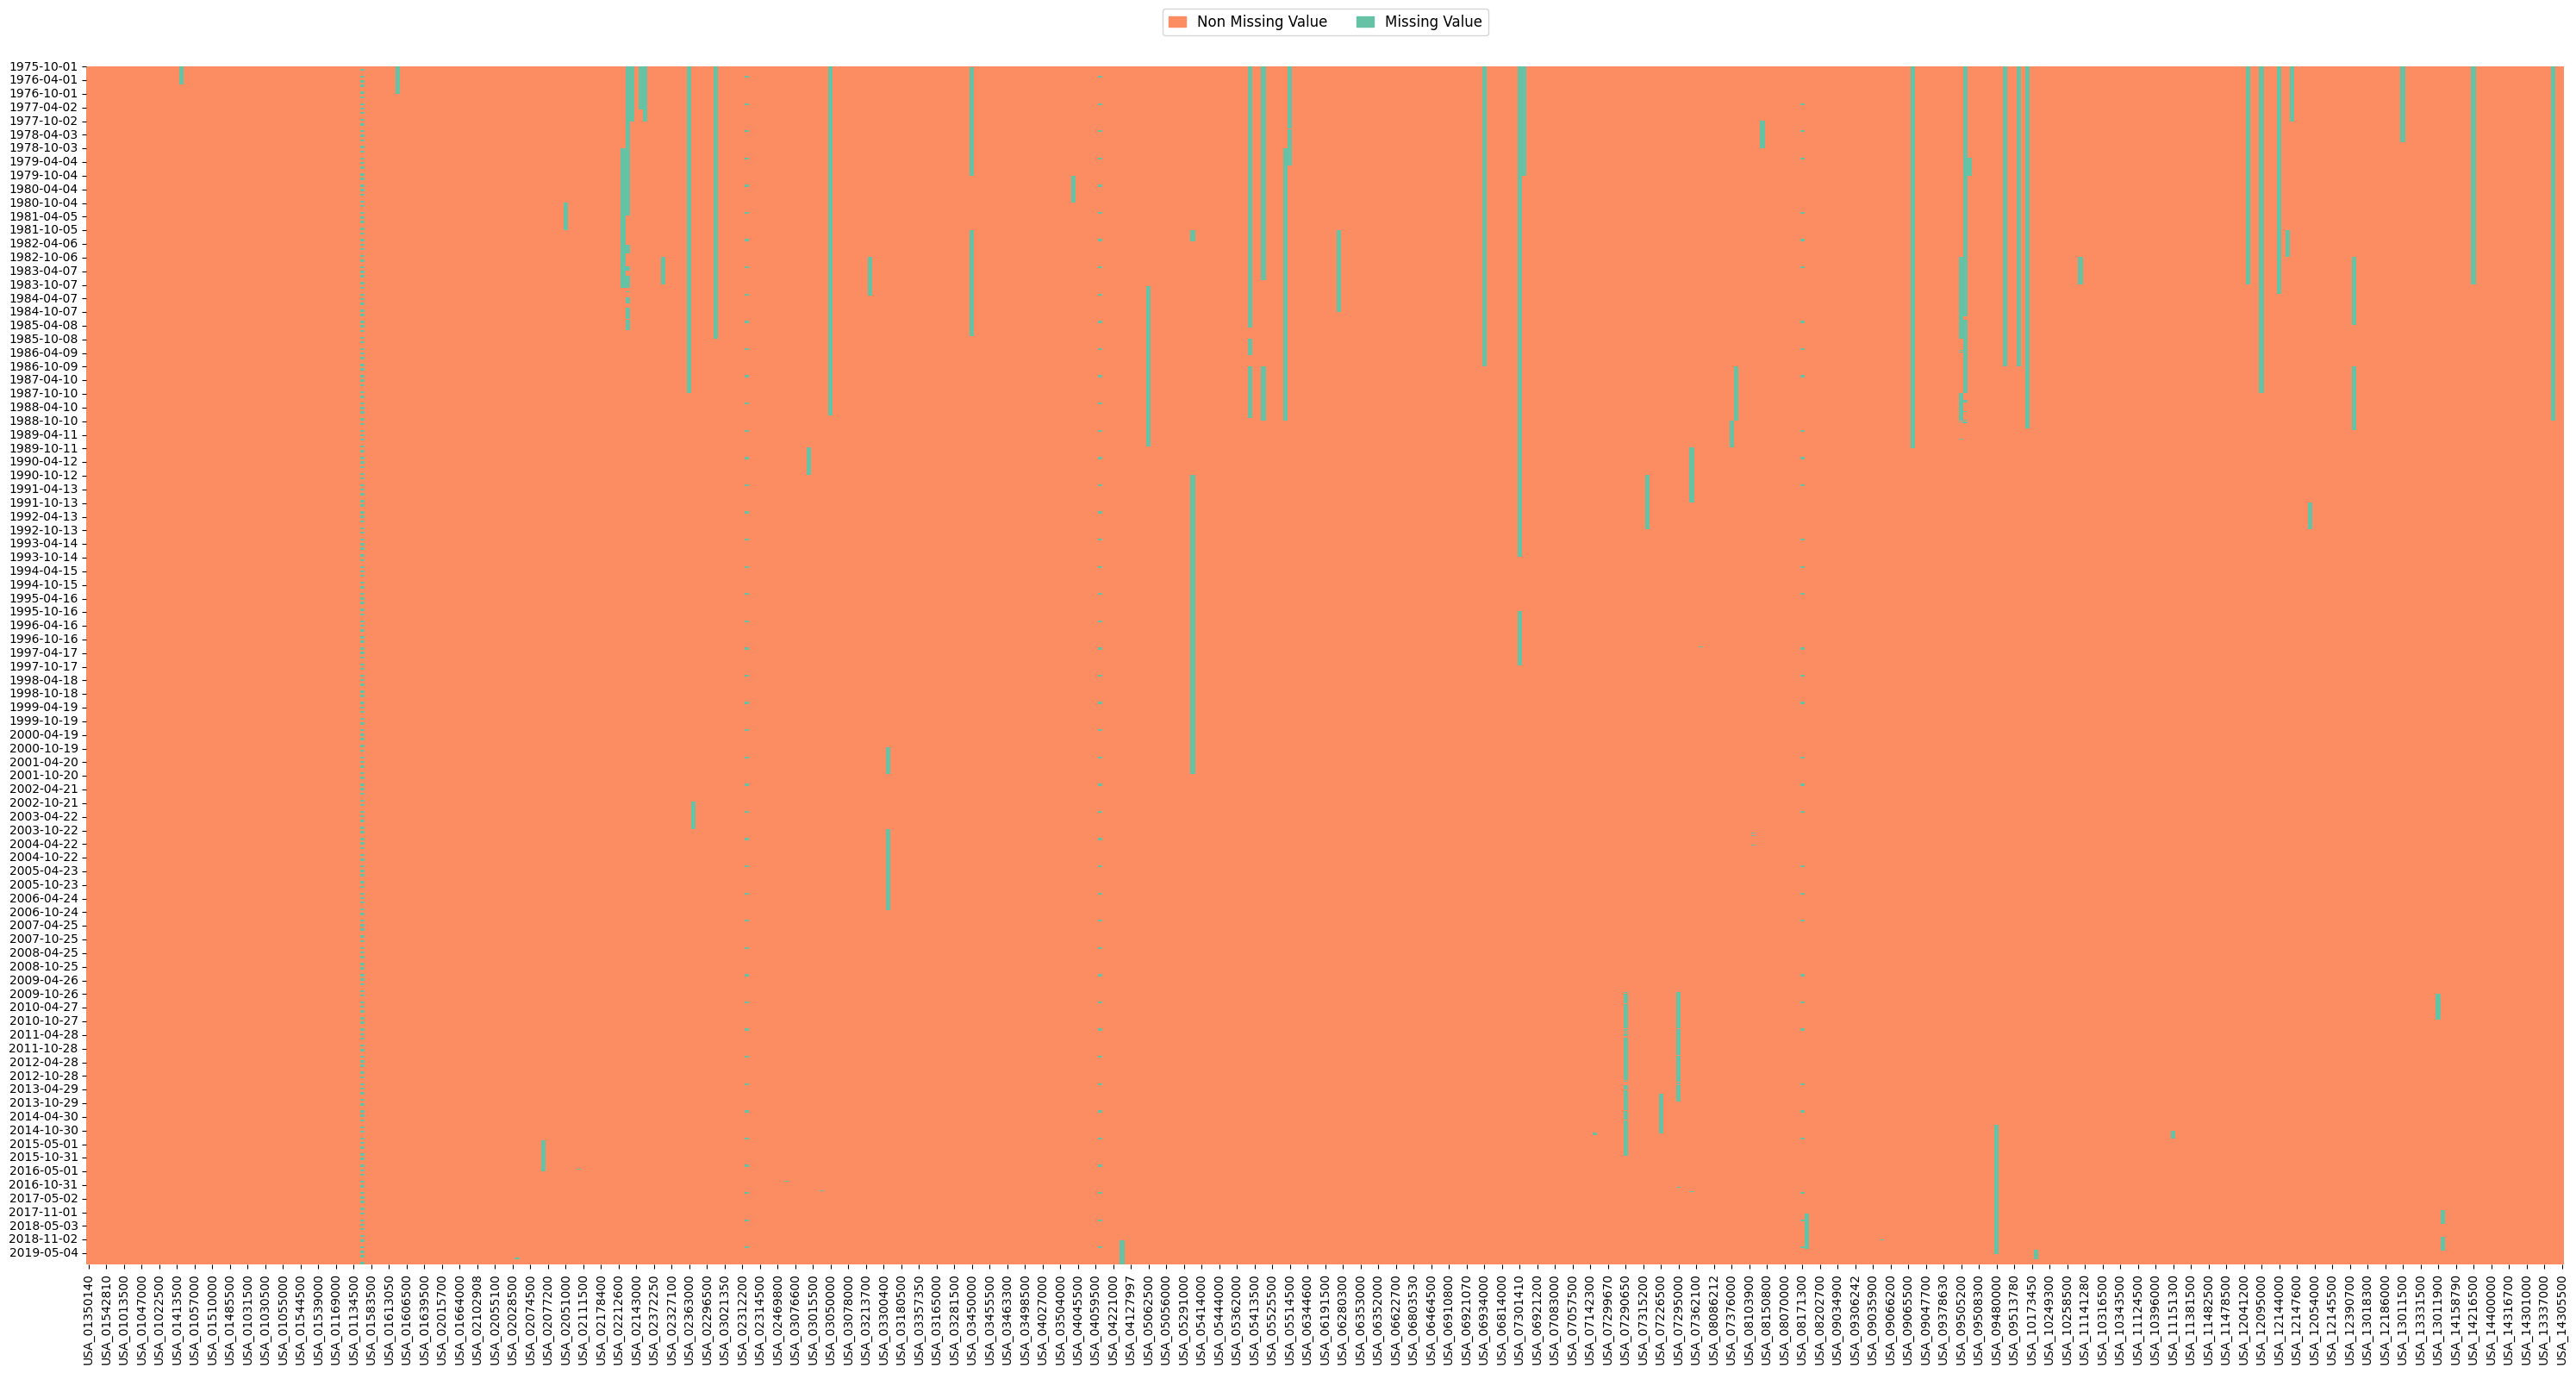

In [6]:
# Rename columns to remove file extension
df_basins_missing.columns = [col.split('.')[0] for col in df_basins_missing.columns]

# Date column to string format and YYYY-MM-DD if needed
if df_basins_missing.index.dtype == 'datetime64[ns]':
    df_basins_missing.index = df_basins_missing.index.strftime('%Y-%m-%d')

plot_missing_data_heatmap(df_basins_missing, dataset, start_year=start_year, end_year=end_year, countries_str=countries_str)